In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
import pandahouse as ph
# import swifter # Ускорялка метода apply
from scipy import stats # Статистика
from scipy.stats import norm, ttest_ind

%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize':(18, 14)}, style='whitegrid')

## Задача.
***
Необходимо определить оптимальный размер выборки для проведения А-Б теста при изменении CTR  5% от среднего знаяения. Эксперимент будет длиться 1 неделю.

***
Для определения размера выборки нам прежде необходимо знать какое минимальное отклонение мы хотим зафиксировать. Далее нам необходимо знать скольно времени мы будем проводить эксперимент

Точкой опоры и спринципом понимания нам будет служить формула (compute_sample_size_abs) расчета размера выборки при учете того что распределение наших данных соответствует критериям нормальности:
- одномодальность;
- симметрия дисперсий;
- отцутствие значительных выбросов.

$$n > \frac{\left[ \Phi^{-1} \left( 1-\alpha \right) + \Phi^{-1} \left( 1-\beta \right) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{\varepsilon^2}$$

Здесь $\varepsilon$ - размер эффекта, $\alpha$ - вероятность ошибки первого рода, $\beta$ - вероятность ошибки 2 рода

Возьмем данные из clickhouse и посмотрим что они из себя представляют.


In [3]:
def compute_sample_size_abs(epsilon: float, std1: float, std2: float, alpha: float = 0.05, beta: float = 0.2) -> int:
    '''
    Для работы необходимо импортировать:
    from scipy.stats import norm
    import numpy as np
    
    Описание функции.
    Формула для расчета размера выборки исходя из того что распределение соответствует критериям нормаоьности и проводится Т-тест.
    alpha - вероятность ошибки 1-го рода, она же уровень значимости. Обычно фиксируется от 0.001 до 0.05;
    beta - вероятность ошибки 2-го рода. Часто его берут равным 0.1 или 0.2;
    std1, std2 - стандартные отклонения в контрольной и экспериментальной группах соответственно;
    epsilon - ожидаемый эффект, т.е. эффект, который мы ожидаем получить от эксперимента. Например, ожидаемый эффект может быть таким — 
              повышение CTR на 0.01. Это означает, что если окажется верна альтернативная гипотеза, а истинный эффект будет 0.01 или более, то мы обнаружим 
              его с вероятностью не менее 1 - beta.
    '''
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (std1 ** 2 + std2 ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

In [4]:
#  Создание соединения с ClickHouse.
connection = {
              'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20231220',
              'user':'student',
              'password':'dpo_python_2020'
             }

In [5]:
# Создаю запрос для выгрузки данных из ClickHouse.
# Взята 1-я группа с 2023-11-18 по 2023-11-24
q = \
"""
SELECT 
   user_id,
   action
FROM simulator_20231220.feed_actions
WHERE toDate(time) between '2023-11-18' and '2023-11-24' and
      exp_group == 1
"""
# Загружаем в датафрейм.
users_df = ph.read_clickhouse(q, connection=connection)

In [6]:
users_df.head()

,user_id,action
0,132126,view
1,116781,like
2,129944,like
3,3903,view
4,125506,view


Преобразуем данные для подсчета CTR

In [7]:
# Создам новую колонку "count". Сгруппирую пользователей по ID, действию.
# Тем самым посчитаю количество действий пользователей.
# Отображу таблицу таким образом, чтобы в столбцах был перечень действий пользователя, а в значениях 
# их количество.
# Так-же у ряда пользователей нет лайков, поэтому NaN значение земеню на "0"
# Периименую колонки.

df = users_df  \
        .assign(count = users_df['action']) \
        .groupby(['user_id', 'action'], as_index=False).agg({'count': 'count'}) \
        .pivot(index=['user_id'], columns='action', values='count').reset_index() \
        .fillna(0) \
        .rename(columns={'like': 'likes', 'view': 'views'})

In [8]:
df.head()

action,user_id,likes,views
0,206,6.0,38.0
1,216,3.0,27.0
2,243,15.0,95.0
3,274,16.0,102.0
4,276,16.0,49.0


In [9]:
df['ctr'] = round(df.likes / df.views, 2)

Text(0.5, 1.0, 'Распределение CTR')

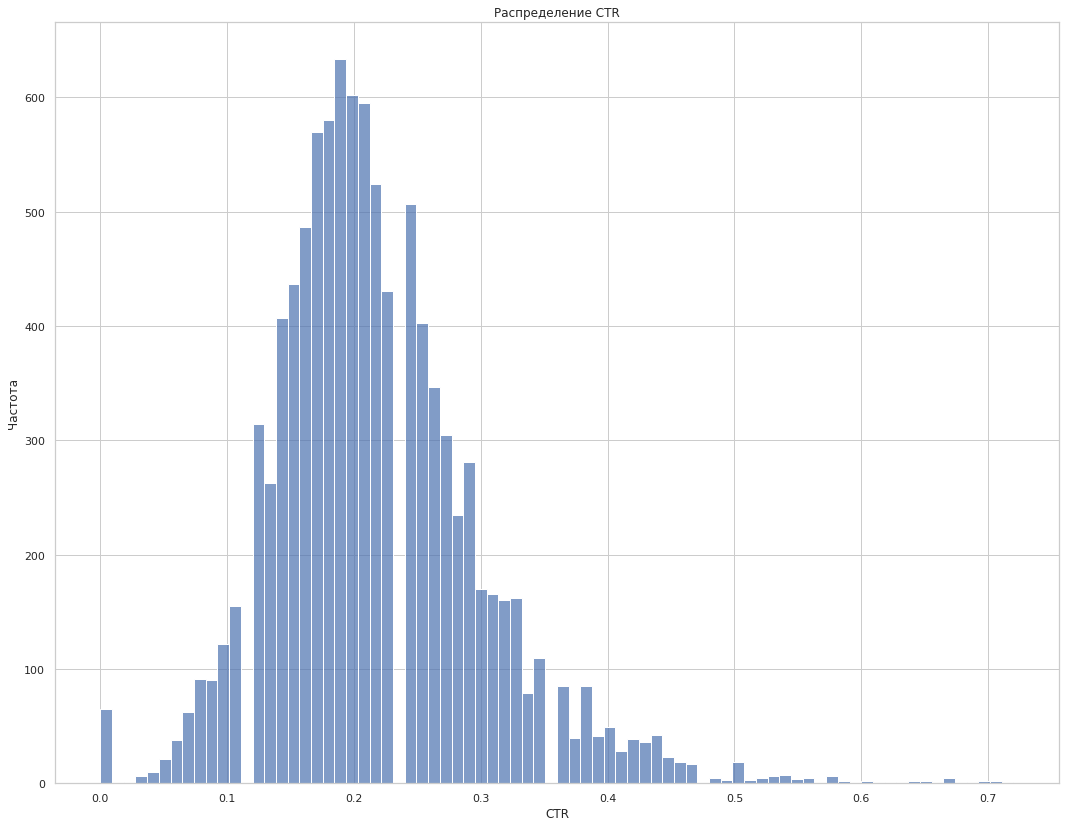

In [10]:
groups = sns.histplot(data = df, 
                      x='ctr',
                      alpha=0.7,
                      kde=False)
plt.xlabel('CTR')
plt.ylabel('Частота')
plt.title('Распределение CTR')

Распределение очень похоже на нормальное. Выбросы есть, но на мой взгляд не критичны.

Посчитаем по формуле какое количество пользователей необходимо для фиксации изменения CTR, согласно заданию

In [11]:
df.ctr.mean()

0.21673453093812378

In [12]:
std_ctr = df.ctr.std()
std_ctr

0.08295601337416815

In [13]:
count_id_ads = compute_sample_size_abs(0.01, std_ctr, std_ctr)

In [14]:
print(f'Согласно растчетам по формуле необходимо {count_id_ads} пользователей.')

Согласно растчетам по формуле необходимо 1081 пользователей.


Проверим так ли это через синтетический А-Б тест. Представим что наша выборка пользователей и есть отражение генеральной совокупности. Сделаем из неё дискретное распределение просмотров и CTR.

In [15]:
df_views = df \
    .groupby("views", as_index=False) \
    .agg({'user_id': 'count'}) \
    .rename(columns={'user_id': 'count_view'})

In [16]:
df_views.head()

action,views,count_view
0,1.0,3
1,2.0,1
2,4.0,2
3,5.0,3
4,6.0,8


In [17]:
df_views['p_view'] = df_views.count_view / df_views.count_view.sum()

In [18]:
df_views.p_view.sum()

1.0

In [19]:
df_views.head()

action,views,count_view,p_view
0,1.0,3,0.000299
1,2.0,1,0.000100
2,4.0,2,0.000200
3,5.0,3,0.000299
4,6.0,8,0.000798


In [20]:
df_ctr = df \
    .groupby('ctr', as_index=False) \
    .agg({'user_id': 'count'}) \
    .rename(columns={'user_id': 'count_ctr'})

In [21]:
df_ctr['p_ctr'] = df_ctr.count_ctr / df_ctr.count_ctr.sum()

In [22]:
df_ctr.p_ctr.sum()

1.0

In [23]:
df_ctr.head()

action,ctr,count_ctr,p_ctr
0,0.00,65,0.006487
1,0.02,1,0.000100
2,0.03,6,0.000599
3,0.04,10,0.000998
4,0.05,21,0.002096


In [24]:
distr_views = stats.rv_discrete(name='distr_views', 
                                values=(df_views['views'], 
                                        df_views['p_view']))

In [25]:
distr_ctr = stats.rv_discrete(name='distr_ctr', 
                                values=(df_ctr['ctr'], 
                                        df_ctr['p_ctr']))

Благодаря созданным распределениям теперь возможно из них, как из эталонов генерировать выборки данных. Будем генерировать из них выборки для двух групп. Одна будет отличаться миещенных CTR на 4,7% в большую сторону.

In [55]:
def sintetic_A_B (count_experiment: int, min_: int, max_: int, step: int, change: float) -> list:
    df_ex = pd.DataFrame()
    list_result = []
    
    for i in range(min_, max_ + step, step):
        group_A_views = distr_views.rvs(size = (count_experiment, i)).astype('int64')
        group_B_views = distr_views.rvs(size = (count_experiment, i)).astype('int64')
        group_A_ctr = distr_ctr.rvs(size = (count_experiment, i)) * change
        group_B_ctr = distr_ctr.rvs(size = (count_experiment, i))
        
        clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
        clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)
        
        
        result = list(map(lambda x: stats.ttest_ind(x[0], x[1]).pvalue, zip(clicks_A / group_A_views, clicks_B / group_B_views)))
        result = np.sum(np.array(result)<= 0.05) / count_experiment
        
        list_result.append(result)
        
    df_ex['count_users'] = range(min_, max_ + step, step)
    df_ex['power_test'] = list_result
    return df_ex

In [59]:
experiment_df = sintetic_A_B(2000, 500, 4000, 100, 1.047)

,count_users,power_test
0,500,0.3350
1,600,0.3840
2,700,0.4150
3,800,0.4740
4,900,0.5210
5,1000,0.5745
6,1100,0.5870
7,1200,0.6250
8,1300,0.6895
9,1400,0.7275


In [61]:
experiment_df.head()

,count_users,power_test
0,500,0.335
1,600,0.384
2,700,0.415
3,800,0.474
4,900,0.521


In [75]:
get_count_id_normslize(1081)

0.8

In [91]:
def get_count_id_normslize(N: int, alpha: float = 0.05, std1: float = std_ctr, std2: float = std_ctr, change: float = 0.01) -> float:
    """
    Переделанная формула расчета размера выборки под растчет мощности теста.
    """
    z_scores_sum_squared = N / ((std1 ** 2 + std2 ** 2) / (change ** 2))
    
    talpha_plus_tbeta = np.sqrt(z_scores_sum_squared)
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = talpha_plus_tbeta - t_alpha
    _1_minus_beta = norm.cdf(t_beta, loc=0, scale=1)
    
    return round(_1_minus_beta, 2)

In [79]:
experiment_df['power_test_norm'] = experiment_df.count_users.apply(get_count_id_normslize)

In [81]:
experiment_df.head()

,count_users,power_test,power_test_norm
0,500,0.335,0.48
1,600,0.384,0.55
2,700,0.415,0.62
3,800,0.474,0.67
4,900,0.521,0.72


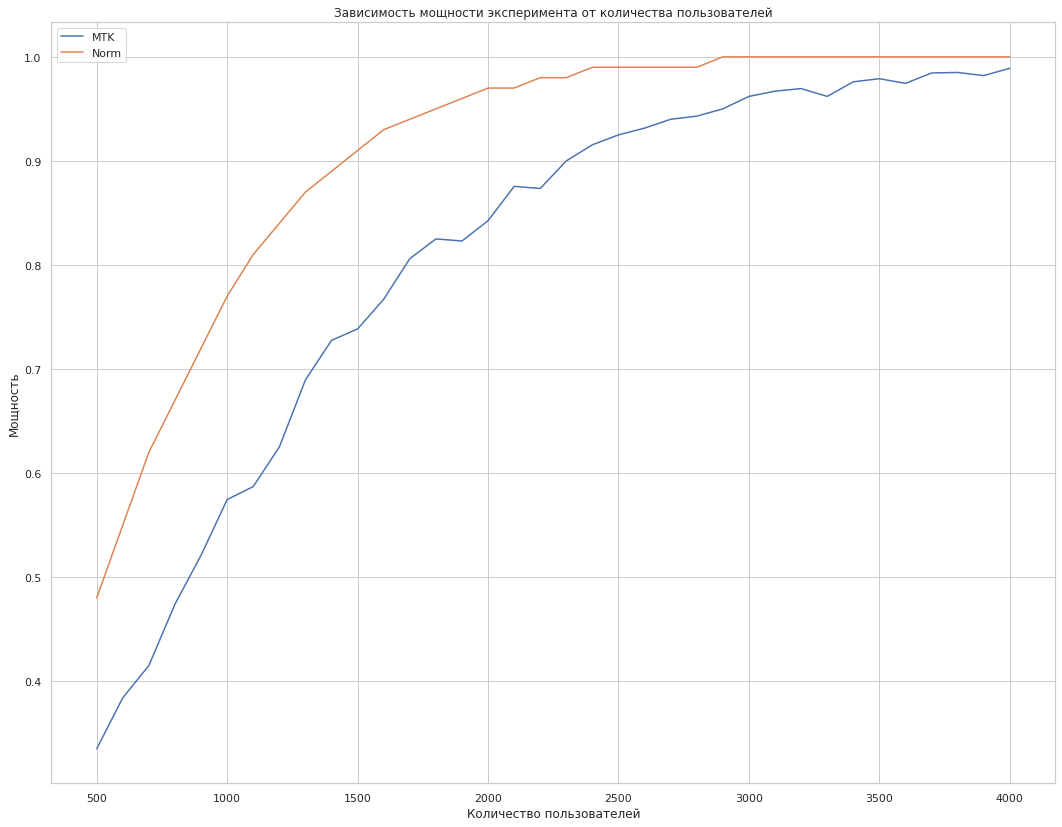

In [90]:
sns.lineplot(data=experiment_df, x='count_users', y='power_test', label='MTK')
sns.lineplot(data=experiment_df, x='count_users', y='power_test_norm', label='Norm')

plt.xlabel('Количество пользователей')
plt.ylabel('Мощность')
plt.title('Зависимость мощности эксперимента от количества пользователей')
plt.legend()
plt.show()

## Выводы
---
При определении количества участников в эксперименте очень важно учитывать исторические данные, их характер распределения. Поэтому проведение синтетического А-Б теста очень важно для более объективного определения размера выборки, с учетом исторических данных. Это поможет в дальнейшем сделать А-Б тест более чувствительным и правильно работающим на историчексих данных. 

В данном случае нам необходимо порядка 1800 пользователей для фиксации изменения CTR не менее чем на 0,01 как минимум в 80% случаев.